In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint

## Caching

hdf5 files can be very large and processing them can take a long time.  However, results can be cached to speed up future access.

To enable caching, specify an `out_dire` when creating the instance of `H5Scan` or `H5Data`.

In [2]:
from e11 import H5Data
fil = os.path.join(os.getcwd(), 'example_data', 'array_data.h5')
data = H5Data(fil, out_dire='analysis')

If `out_dire` is specified then `cache_dire` is created as a sub directory of it.

In [3]:
print(data.cache_dire)

C:\Users\Adam\Documents\Git\e11_analysis\notebooks\example_data\analysis\cache


The first time that an instance of `H5Data(fil)` is created the log will be cached as `[cache_dire]/log.pkl`.

An update of the log can be forced at any time using the method `H5Data.update_log()`.

In [4]:
data.__class__

e11.core.H5Data

Caching is also available for the methods: `array()`, `df()`, and `apply()`.  It is disabled by default but can be enabled using the kwarg "cache".

In [5]:
# First call of data.df(). Data is read from the hdf5 file.
%time av = data.df(data.squids, 'AV_0', \
                   label=None, \
                   ignore_missing=False, \
                   cache="av_0", \
                   update_cache=True)
av.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 429.66it/s]


Wall time: 42.9 ms


AB        CD        EF
squid measurement                              
1     0            0.983765  0.984008  0.004351
      1            0.984163  0.984424  0.004799
      2            0.983991  0.984383  0.004606
      3            0.983983  0.984222  0.004568
      4            0.983856  0.984048  0.004349

Future calls of same method will return the cached result.

In [6]:
# Next call of data.df(). Data is loaded from the cache (quicker).
%time av, info = data.df(data.squids, 'AV_0', \
                         label=None, \
                         ignore_missing=False, \
                         cache="av_0", \
                         get_info=True)
av.head()

Wall time: 2 ms


AB        CD        EF
squid measurement                              
1     0            0.983765  0.984008  0.004351
      1            0.984163  0.984424  0.004799
      2            0.983991  0.984383  0.004606
      3            0.983983  0.984222  0.004568
      4            0.983856  0.984048  0.004349

With `get_info=True`, information about the method call (e.g., args and kwargs values) are returned alongside the result.

In [7]:
pprint(info)

{'cache': 'C:\\Users\\Adam\\Documents\\Git\\e11_analysis\\notebooks\\example_data\\analysis\\cache\\av_0.df.pkl',
 'dataset': 'AV_0',
 'datetime': '2019-01-25 18:46:19',
 'ignore_missing': False,
 'label': None,
 'method': 'df',
 'self': 'H5Data',
 'squids': array([1, 2, 3, 4, 5, 6])}


The cost of caching is the extra disc space required. The gain is faster future access to subsets of the data.  The speed-up is especially significant when using `data.apply()` with high-level processing techniques, such as searching data for trigger events.

 To force an overwrite of an existing cache, call the method with  `cache_update=True`.

## Read from the cache

Reading from the cache is automatic for repeat calls of a compatible method.  However, files in the cache are simply a pickle of the method result [and cache_info], and can be read manually.

To read the contents of the cache directory:

In [8]:
from e11.tools import ls
ls(data.cache_dire)

['C:\\Users\\Adam\\Documents\\Git\\e11_analysis\\notebooks\\example_data\\analysis\\cache\\av_0.df.pkl',
 'C:\\Users\\Adam\\Documents\\Git\\e11_analysis\\notebooks\\example_data\\analysis\\cache\\log.pkl']

In [9]:
fils = ls(data.cache_dire, regex="*.df.pkl")
pprint(fils)

['C:\\Users\\Adam\\Documents\\Git\\e11_analysis\\notebooks\\example_data\\analysis\\cache\\av_0.df.pkl']


In [10]:
%time result, info = pd.read_pickle(fils[0])
pprint(info)

Wall time: 1.99 ms
{'dataset': 'AV_0',
 'datetime': '2019-01-25 18:46:19',
 'ignore_missing': False,
 'label': None,
 'method': 'df',
 'self': 'H5Data',
 'squids': array([1, 2, 3, 4, 5, 6])}


In [11]:
result.head()

AB        CD        EF
squid measurement                              
1     0            0.983765  0.984008  0.004351
      1            0.984163  0.984424  0.004799
      2            0.983991  0.984383  0.004606
      3            0.983983  0.984222  0.004568
      4            0.983856  0.984048  0.004349

## Saving to out_dire

`H5Data.out_dire` is also useful for saving files that are related to the data, e.g., analysis results or plots.

To quickly build paths to sub directories of `out_dire` use the function `e11_tools.sub_dire()`.

In [12]:
from e11.tools import sub_dire
fname = sub_dire(data.out_dire, 'plots', fname='signal.png')
print(fname)

C:\Users\Adam\Documents\Git\e11_analysis\notebooks\example_data\analysis\plots\signal.png


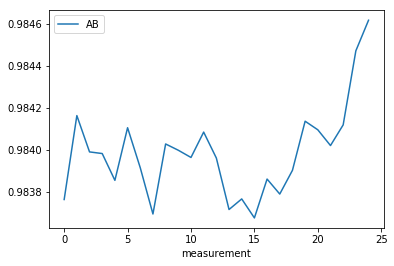

In [13]:
fig, ax = plt.subplots()

result.loc[1].plot(y="AB", ax=ax)

plt.savefig(fname, bbox_inches="tight", dpi=300)
plt.show()